## Getting the dataset ready for model training
- Download dataset into tf
- Data cleaning
- Make dataset ready for training


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #for rgb channels
EPOCHS = 50
n_classes = 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = "../PlantVillage",
    shuffle = True, 
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset) #because everything in the dataset is a batch of 32 , 68 * 32 = 2152

68

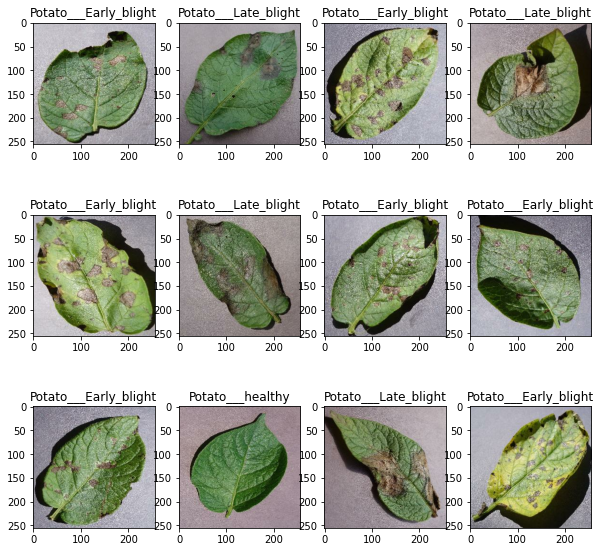

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1) :
    #displaying 12 images from a batch of 32 :
    for i in range(12) :
        ax = plt.subplot(3,4,i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])

### Training and Testing split
- 80 % -> training
- 20 % -> 10 % validation (used after every epoch) 10 % test 

In [12]:
def get_dataset_partitions_tf(ds,train_split = 0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 100) :
    
    if shuffle :
        ds = ds.shuffle(shuffle_size)
        
    train_size = int(0.8 * len(ds))
    train_ds = dataset.take(train_size)
    
    
    test_val_ds = dataset.skip(train_size) 
    
    val_size = int(len(ds) * 0.1)
    val_ds = test_val_ds.take(val_size)
    
    test_ds = test_val_ds.skip(val_size)
    
    return train_ds,val_ds,test_ds

In [13]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#when we read an image, and we have to read that image again, it stores it in the memory and improves performance

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), #our train/test images are this size, but this is added for prediction, if a user puts an image of some other size.
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [17]:
#now we are doing data-augmentation to make our model more robust.

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])



In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building CNN  

In [40]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = models.Sequential([
    
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3) ,activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [41]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (32, 60, 60, 64)         

In [42]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [43]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 110s 2s/step - loss: 0.9127 - accuracy: 0.4850 - val_loss: 0.8423 - val_accuracy: 0.4219
Epoch 2/50
54/54 [==============================] - 130s 2s/step - loss: 0.7057 - accuracy: 0.6632 - val_loss: 0.4467 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 136s 3s/step - loss: 0.4069 - accuracy: 0.8235 - val_loss: 0.3303 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 105s 2s/step - loss: 0.3787 - accuracy: 0.8438 - val_loss: 0.3942 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 105s 2s/step - loss: 0.3009 - accuracy: 0.8785 - val_loss: 0.2568 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 103s 2s/step - loss: 0.2555 - accuracy: 0.8924 - val_loss: 0.2286 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 101s 2s/step - loss: 0.2209 - accuracy: 0.9109 - val_loss: 0.4498 - val_accuracy: 0.8177
Epoch 8/50
54

In [45]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 10s 392ms/step - loss: 0.1592 - accuracy: 0.9741


In [46]:
scores

[0.1591571867465973, 0.9741379022598267]

In [47]:
history

In [48]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [49]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
max(history.history['accuracy'])

0.9994212985038757

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

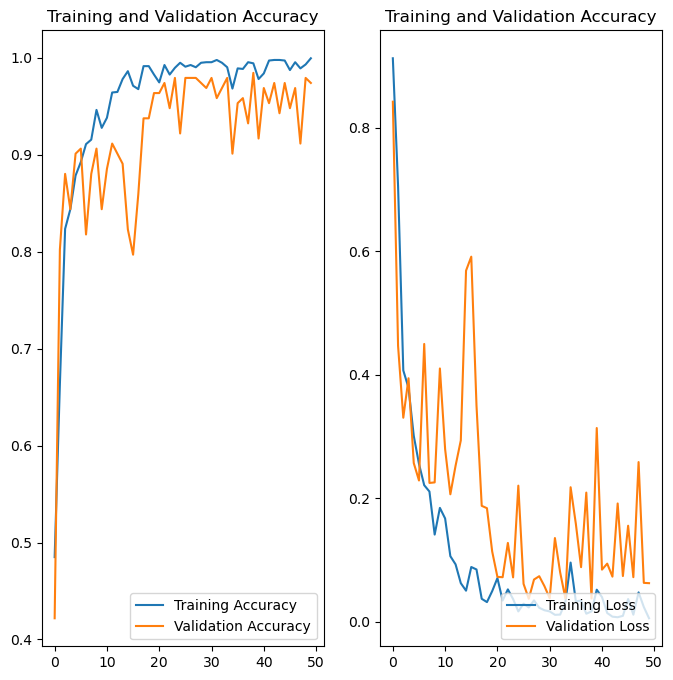

In [54]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = "Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = "Training Loss")
plt.plot(range(EPOCHS),val_loss,label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

The actual label for the image :  Potato___Early_blight
1/1 [==============================] - 0s 380ms/step
predicted label :  Potato___Early_blight


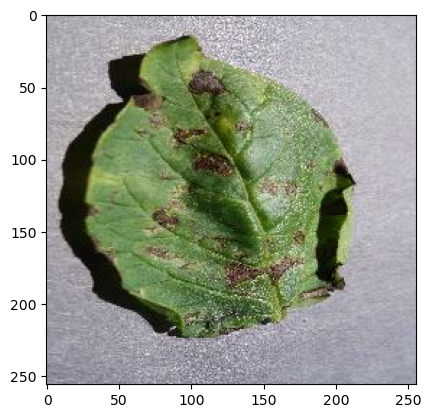

In [65]:
import numpy as np
for image_batch,label_batch in dataset.take(1) :
    print("The actual label for the image : ",class_names[label_batch[0].numpy()])
    plt.imshow(image_batch[0].numpy().astype('uint8'))
    
    batch_prediction = model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model,img) :
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 34ms/step


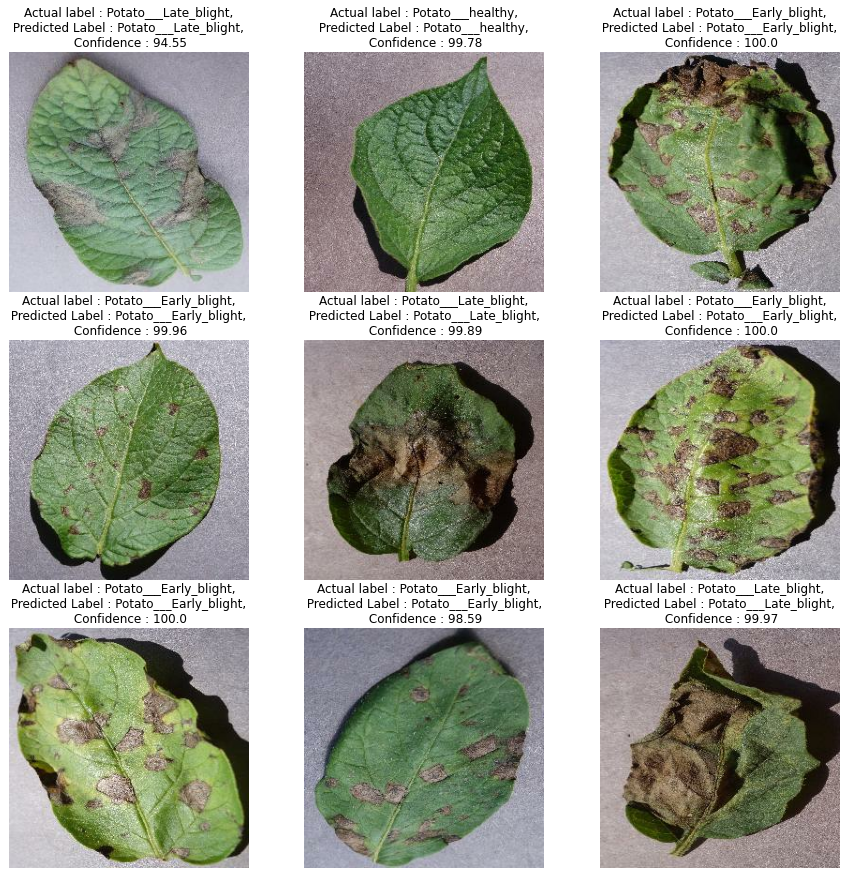

In [50]:
plt.figure(figsize = (15,15))

for images,labels in dataset.take(1) :
    for i in range(9) :
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        predicted_class,confidence = predict(model,images[i].numpy())

        actual_label = class_names[labels[i]]
        
        plt.title(f"Actual label : {actual_label},\n Predicted Label : {predicted_class}, \n Confidence : {confidence}")

In [82]:
model_version = 1
model.save(f"/models/{model_version}")

INFO:tensorflow:Assets written to: /models/1\assets


INFO:tensorflow:Assets written to: /models/1\assets


## Building a second Model


In [33]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3) ,activation = 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size =(3,3) ,activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax')
])

model.build(input_shape = input_shape)

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (32, 60, 60, 64)         

In [35]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [36]:
EPOCHS = 25
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/25
54/54 [==============================] - 130s 2s/step - loss: 0.8865 - accuracy: 0.4902 - val_loss: 0.7884 - val_accuracy: 0.5729
Epoch 2/25
54/54 [==============================] - 127s 2s/step - loss: 0.5900 - accuracy: 0.7326 - val_loss: 0.4166 - val_accuracy: 0.8333
Epoch 3/25
54/54 [==============================] - 122s 2s/step - loss: 0.3058 - accuracy: 0.8553 - val_loss: 0.1891 - val_accuracy: 0.9375
Epoch 4/25
54/54 [==============================] - 123s 2s/step - loss: 0.2206 - accuracy: 0.9091 - val_loss: 0.2306 - val_accuracy: 0.9010
Epoch 5/25
54/54 [==============================] - 122s 2s/step - loss: 0.1645 - accuracy: 0.9340 - val_loss: 0.0672 - val_accuracy: 0.9740
Epoch 6/25
54/54 [==============================] - 121s 2s/step - loss: 0.1186 - accuracy: 0.9572 - val_loss: 0.1215 - val_accuracy: 0.9635
Epoch 7/25
54/54 [==============================] - 123s 2s/step - loss: 0.1857 - accuracy: 0.9259 - val_loss: 0.1996 - val_accuracy: 0.9167
Epoch 8/25
54

In [40]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [37]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 381ms/step - loss: 0.1113 - accuracy: 0.9612


In [41]:
scores

[0.11134400218725204, 0.9612069129943848]

In [38]:
model_version = 2
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets


In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

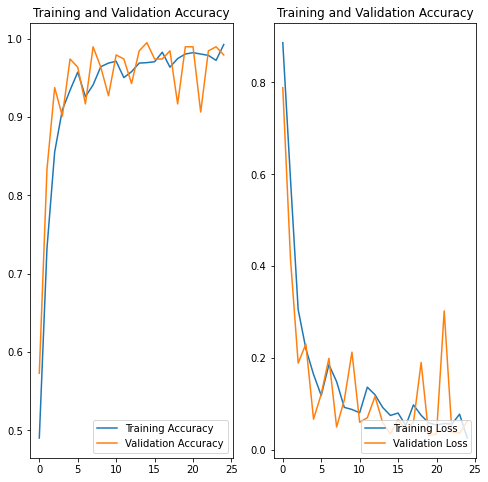

In [43]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = "Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = "Training Loss")
plt.plot(range(EPOCHS),val_loss,label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

1/1 [==============================] - 0s 45ms/step


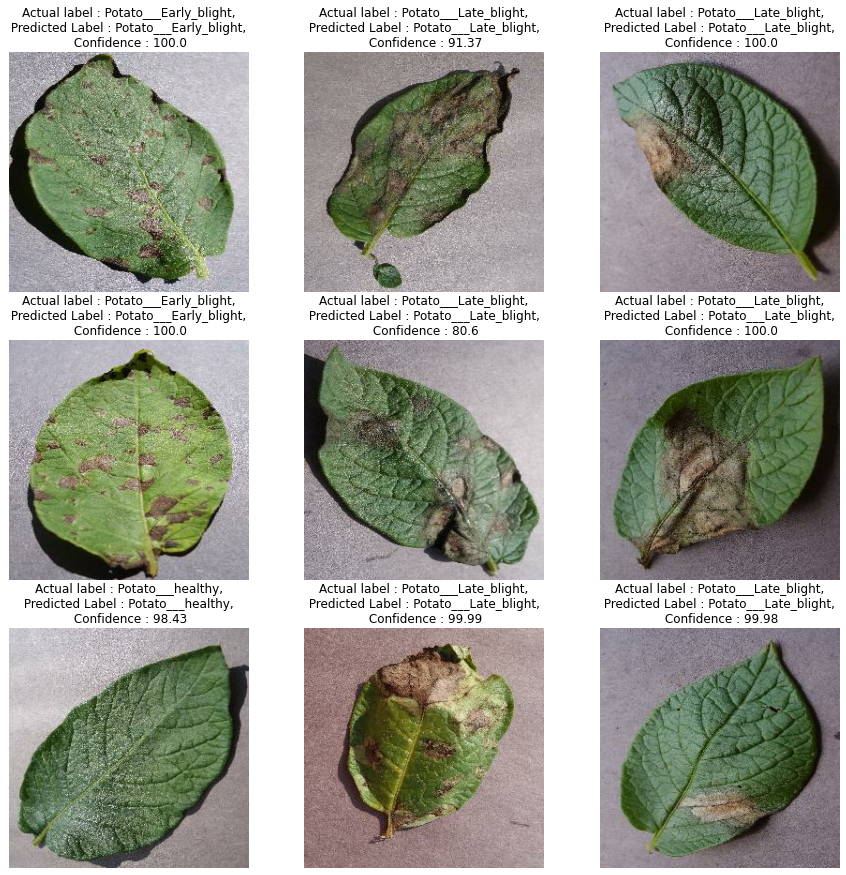

In [51]:
import numpy as np
plt.figure(figsize = (15,15))
for images,labels in dataset.take(1) :
    for i in range(9) :
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        predicted_class,confidence = predict(model,images[i].numpy())

        actual_label = class_names[labels[i]]
        
        plt.title(f"Actual label : {actual_label},\n Predicted Label : {predicted_class}, \n Confidence : {confidence}")